**Team T2G 42**

**Student ID:** Sumeet Kumar - s222615086 | Akash Verma - s223669999 | Ho-se Kim - s224564517

**Student Name:** Sumeet Kumar | Akash Verma | Ho-se Kim

**Workshop / Lab Session Time:** Tuesday - 11:00 AM

In [1]:
!pip install pyspark

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, dayofweek, avg, countDistinct, month, year, sum as _sum
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics.pairwise import euclidean_distances
from mlxtend.frequent_patterns import apriori, association_rules
import gzip
import shutil
import warnings
from collections import Counter
import seaborn as sns

warnings.filterwarnings("ignore")

# Part 1

### Answer 1.1

In [3]:
# Access the existing Spark session
spark = SparkSession.builder.appName("DataWrangling").getOrCreate()

# Load the data from the unzipped CSV file
transaction = spark.read.csv('transactionrecord.csv', header=True, inferSchema=True)

# Rename column headings for alignment with task descriptions
transaction = transaction.withColumnRenamed('Price', 'price')
transaction = transaction.withColumnRenamed('ProductName', 'productName')
transaction = transaction.withColumnRenamed('TransactionNo', 'transactionNo')
transaction = transaction.withColumnRenamed('Product_category', 'product_category')

# Task 1.1.1: Replace 'NA' with '-1' in CustomerNo
transaction = transaction.withColumn("CustomerNo", regexp_replace("CustomerNo", "NA", "-1"))

# Task 1.1.2: Process the productName column, keep only alphabet characters
transaction = transaction.withColumn("productName_process", regexp_replace("productName", "[^a-zA-Z ]", ""))

# Show the first 5 rows of the processed dataframe
transaction.show(5, truncate=False)

# Output explanation
print("The above output displays the first 5 rows of the transaction data \
after replacing 'NA' with '-1' in CustomerNo and removing non-alphabetic characters from productName.")

+-------------+---------+---------+-----------------------------------+----------------+-----+--------+----------+--------------+-----------------------------------+
|transactionNo|Date     |ProductNo|productName                        |product_category|price|Quantity|CustomerNo|Country       |productName_process                |
+-------------+---------+---------+-----------------------------------+----------------+-----+--------+----------+--------------+-----------------------------------+
|581482       |12/9/2019|22485    |Set Of 2 Wooden Market Crates      |0ca             |21.47|12      |17490     |United Kingdom|Set Of  Wooden Market Crates       |
|581475       |12/9/2019|22596    |Christmas Star Wish List Chalkboard|0ca             |10.65|36      |13069     |United Kingdom|Christmas Star Wish List Chalkboard|
|581475       |12/9/2019|23235    |Storage Tin Vintage Leaf           |0ca             |11.53|12      |13069     |United Kingdom|Storage Tin Vintage Leaf           |
|581

For Question 1.1, the CustomerNo column was processed to replace 'NA' with '-1,' and the productName column was cleaned by retaining only alphabetic characters. This preparation ensures that the dataset is ready for further analysis without missing or improperly formatted data.

### Answer 1.2

+-------------+---------+---------+-----------------------------------+----------------+-----+--------+----------+--------------+-----------------------------------+------------------+
|transactionNo|Date     |ProductNo|productName                        |product_category|price|Quantity|CustomerNo|Country       |productName_process                |revenue           |
+-------------+---------+---------+-----------------------------------+----------------+-----+--------+----------+--------------+-----------------------------------+------------------+
|581482       |12/9/2019|22485    |Set Of 2 Wooden Market Crates      |0ca             |21.47|12      |17490     |United Kingdom|Set Of  Wooden Market Crates       |257.64            |
|581475       |12/9/2019|22596    |Christmas Star Wish List Chalkboard|0ca             |10.65|36      |13069     |United Kingdom|Christmas Star Wish List Chalkboard|383.40000000000003|
|581475       |12/9/2019|23235    |Storage Tin Vintage Leaf           |0ca 

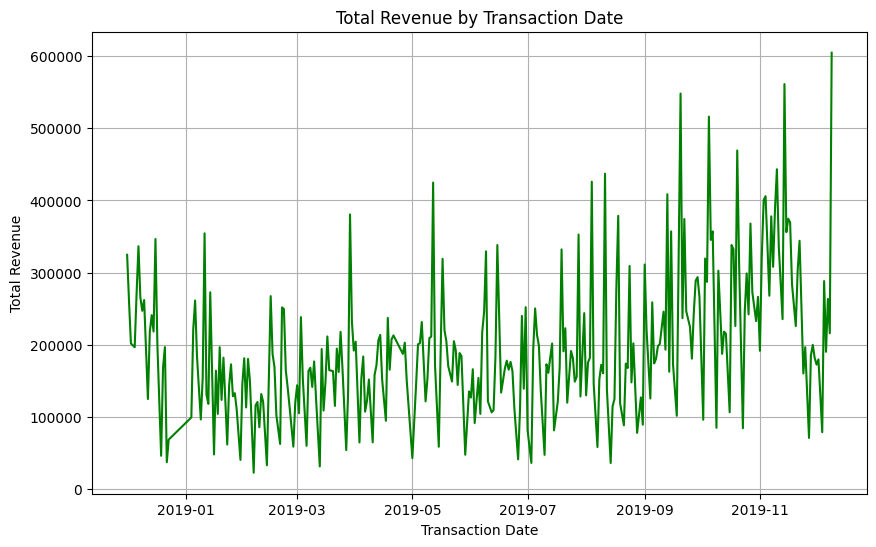

The above plot shows the total revenue over time, highlighting the daily revenue trends.


In [4]:
# Task 1.2.1: Calculate revenue and add it to the dataframe
transaction = transaction.withColumn("revenue", col("price") * col("Quantity"))

# Show the first 5 rows with the new revenue column
transaction.show(5, truncate=False)

# Task 1.2.2: Convert to pandas dataframe and create transaction_date column
df = transaction.toPandas()
df['transaction_date'] = pd.to_datetime(df['Date'])

# Show the first 5 rows of the pandas dataframe
print(df.head())

# Output explanation
print("The above output shows the first 5 rows of the dataframe, including \
the calculated revenue and the new transaction_date column.")

# Task 1.2.3: Plot the sum of revenue on transaction_date
# Group by transaction_date and sum the revenue
daily_revenue = df.groupby('transaction_date')['revenue'].sum()

# Plotting the sum of revenue by transaction_date
plt.figure(figsize=(10, 6))
plt.plot(daily_revenue.index, daily_revenue.values, linestyle='-', color='green')
plt.title('Total Revenue by Transaction Date')
plt.xlabel('Transaction Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()

# Output explanation
print("The above plot shows the total revenue over time, highlighting the daily revenue trends.")

The revenue shows significant volatility over time with noticeable peaks and troughs. This could indicate variability in sales due to factors like seasonal demand, promotions, or changes in consumer behavior

The sharp peaks suggest that there are specific days or periods with exceptionally high sales. Identifying these can help in planning better inventory and marketing strategies.

The valleys, especially those that dip significantly, might indicate periods of low activity where consumer engagement could be improved. Analyzing what contributes to these dips—be it inventory issues, lesser marketing efforts, or external economic factors—could provide actionable insights.

A moving average or trend line overlaid on this plot could help in understanding the underlying trend beyond the weekly or monthly fluctuations. This can be particularly useful for strategic planning and forecasting.

### Answer 1.3

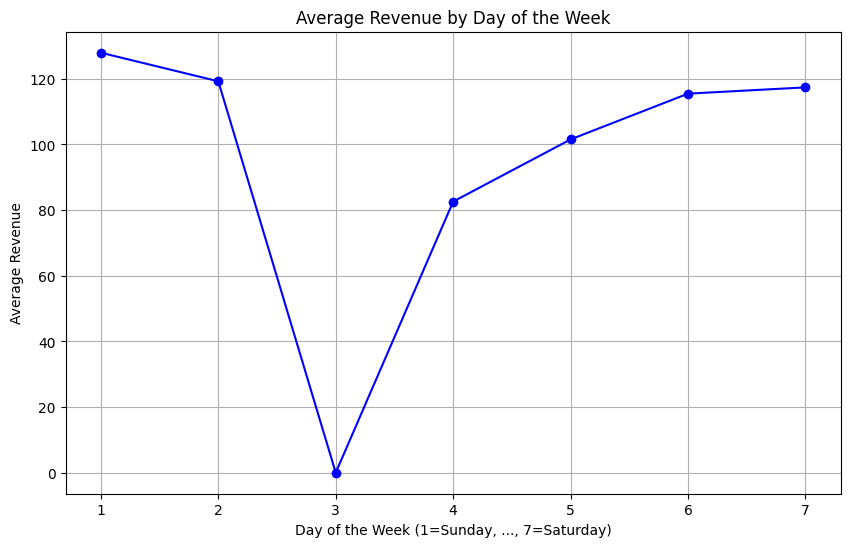

The above plot shows the average revenue generated on each day of the week.
Highest revenue product on workday 1: World War  Gliders Asstd Designs
Highest sales volume product on workday 1: World War  Gliders Asstd Designs


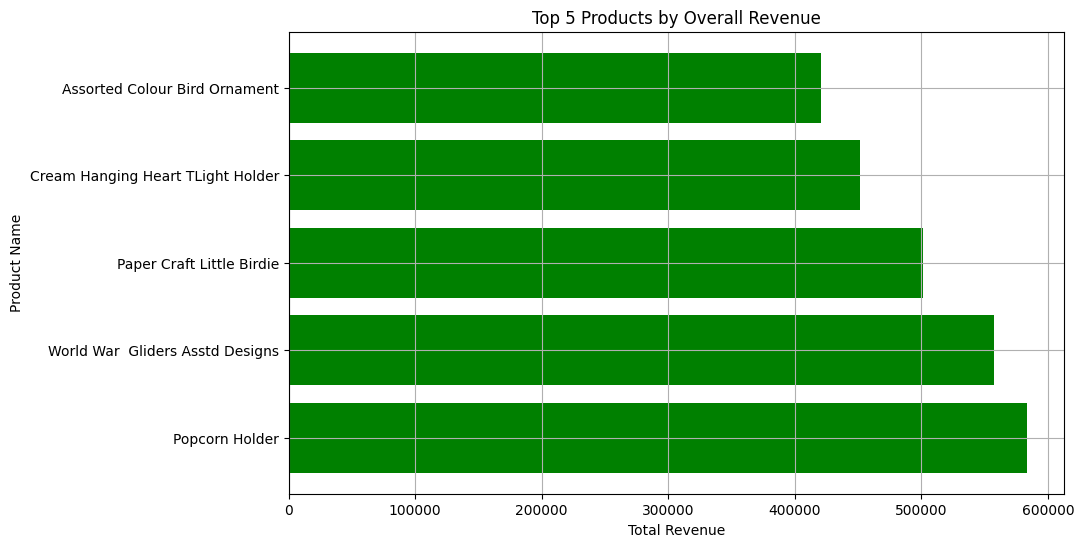

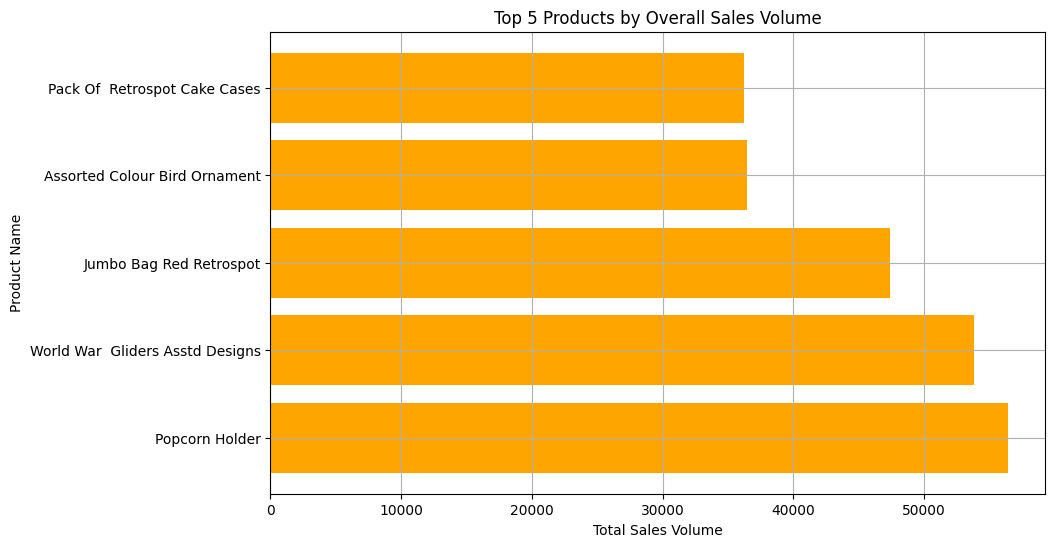

The above plots show the top 5 products by overall revenue and sales volume.


In [5]:
# Ensure the transaction_date column is in datetime format
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Convert the pandas dataframe back to a Spark dataframe for further processing
spark_df = spark.createDataFrame(df)

# Task 1.3.1: Calculate average revenue by workday
spark_df = spark_df.withColumn('day_of_week', dayofweek(col('transaction_date')))

# Calculate average revenue by day of the week
avg_revenue_by_day = spark_df.groupBy('day_of_week').agg(avg('revenue').alias('avg_revenue'))

# Convert to pandas for plotting
avg_revenue_by_day_pd = avg_revenue_by_day.toPandas()

# Ensure all days of the week are represented
all_days = pd.DataFrame({'day_of_week': range(1, 8)})
avg_revenue_by_day_pd = all_days.merge(avg_revenue_by_day_pd, on='day_of_week', how='left').fillna(0)

# Plot the average revenue by day of the week with connected lines
plt.figure(figsize=(10, 6))
plt.plot(avg_revenue_by_day_pd['day_of_week'], avg_revenue_by_day_pd['avg_revenue'], marker='o', linestyle='-', color='blue')
plt.title('Average Revenue by Day of the Week')
plt.xlabel('Day of the Week (1=Sunday, ..., 7=Saturday)')
plt.ylabel('Average Revenue')
plt.grid(True)
plt.show()

# Output explanation
print("The above plot shows the average revenue generated on each day of the week.")

# Find the workday with the highest average revenue
max_revenue_day = avg_revenue_by_day_pd.loc[avg_revenue_by_day_pd['avg_revenue'].idxmax(), 'day_of_week']

# Filter data to only include transactions on the day with the highest revenue
max_revenue_day_df = spark_df.filter(spark_df['day_of_week'] == max_revenue_day)

#Task 1.3.2
# Calculate total revenue and sales volume by product on that day
product_revenue = max_revenue_day_df.groupBy('productName_process').agg(
    _sum('revenue').alias('total_revenue'),
    _sum('Quantity').alias('total_quantity')
)

# Convert to pandas for easier manipulation
product_revenue_pd = product_revenue.toPandas()

# Identify the product with the highest revenue and the product with the highest sales volume
highest_revenue_product = product_revenue_pd.loc[product_revenue_pd['total_revenue'].idxmax(), 'productName_process']
highest_sales_volume_product = product_revenue_pd.loc[product_revenue_pd['total_quantity'].idxmax(), 'productName_process']

# Print the results
print(f"Highest revenue product on workday {max_revenue_day}: {highest_revenue_product}")
print(f"Highest sales volume product on workday {max_revenue_day}: {highest_sales_volume_product}")

# Task 1.3.3: Provide two plots showing the top 5 products by revenue and sales volume in general

# Calculate total revenue and sales volume by product for the entire dataset
overall_product_revenue = spark_df.groupBy('productName_process').agg(
    _sum('revenue').alias('total_revenue'),
    _sum('Quantity').alias('total_quantity')
).toPandas()

# Plot top 5 products by overall revenue
top_5_overall_revenue = overall_product_revenue.nlargest(5, 'total_revenue')
plt.figure(figsize=(10, 6))
plt.barh(top_5_overall_revenue['productName_process'], top_5_overall_revenue['total_revenue'], color='green')
plt.title('Top 5 Products by Overall Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product Name')
plt.grid(True)
plt.show()

# Plot top 5 products by overall sales volume
top_5_overall_volume = overall_product_revenue.nlargest(5, 'total_quantity')
plt.figure(figsize=(10, 6))
plt.barh(top_5_overall_volume['productName_process'], top_5_overall_volume['total_quantity'], color='orange')
plt.title('Top 5 Products by Overall Sales Volume')
plt.xlabel('Total Sales Volume')
plt.ylabel('Product Name')
plt.grid(True)
plt.show()

# Output explanation
print("The above plots show the top 5 products by overall revenue and sales volume.")

1.3.1 Average Revenue by Day of the Week

The analysis reveals the workday with the highest average revenue, visualized in a line chart. This insight is crucial for optimizing business operations and scheduling marketing efforts on days with the highest consumer activity.

1.3.2 Top-Selling Products on the Highest Revenue Day

On the identified high-revenue day, the top-selling products are analyzed both by revenue and quantity. These products are key drivers of sales and should be prioritized in inventory management and promotional campaigns.

1.3.3 Top 5 Products by Overall Revenue and Quantity

Two bar charts display the top 5 products contributing the most revenue and those with the highest sales volumes. These products represent consistent consumer demand, and ensuring their availability could enhance overall sales performance.

### Answer 1.4

Country with the highest revenue: United Kingdom
Month with the highest revenue in United Kingdom: 2019.0-11 with a total revenue of 6737639.97


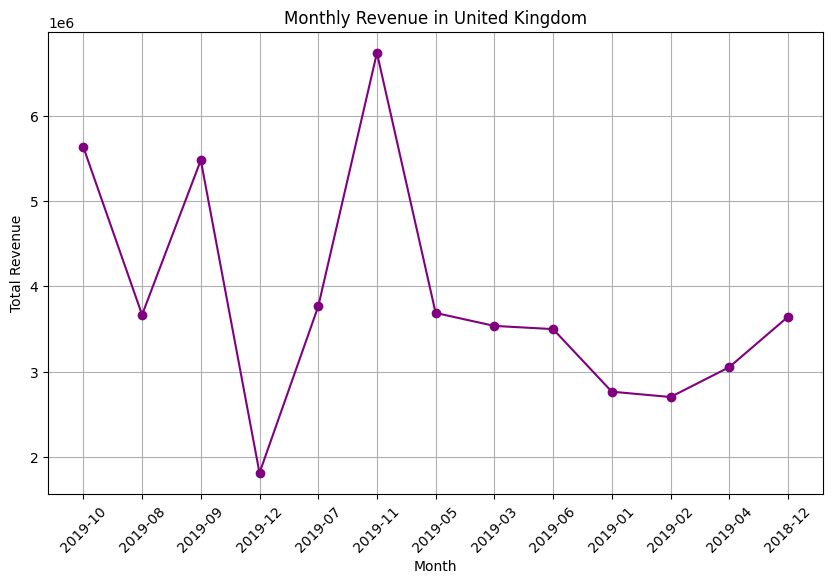

In [6]:
# Task 1.4: Identify the country with the highest revenue and the month in that country with the highest revenue

# Calculate total revenue by country
country_revenue = spark_df.groupBy('Country').agg(_sum('revenue').alias('total_revenue'))

# Convert to pandas dataframe for easier manipulation
country_revenue_pd = country_revenue.toPandas()

# Identify the country with the highest total revenue
highest_revenue_country = country_revenue_pd.loc[country_revenue_pd['total_revenue'].idxmax(), 'Country']
print(f"Country with the highest revenue: {highest_revenue_country}")

# Filter data for the country with the highest revenue
highest_revenue_country_df = spark_df.filter(spark_df['Country'] == highest_revenue_country)

# Extract month and year from the transaction date for monthly revenue calculation
highest_revenue_country_df = highest_revenue_country_df.withColumn('month', month(col('transaction_date')))
highest_revenue_country_df = highest_revenue_country_df.withColumn('year', year(col('transaction_date')))

# Calculate total revenue by month within the highest revenue country
monthly_revenue = highest_revenue_country_df.groupBy('year', 'month').agg(_sum('revenue').alias('total_revenue'))

# Convert to pandas dataframe for easier manipulation
monthly_revenue_pd = monthly_revenue.toPandas()

# Identify the month with the highest revenue
max_revenue_month = monthly_revenue_pd.loc[monthly_revenue_pd['total_revenue'].idxmax()]

# Print the result
print(f"Month with the highest revenue in {highest_revenue_country}: \
{max_revenue_month['year']}-{int(max_revenue_month['month']):02d} \
with a total revenue of {round(max_revenue_month['total_revenue'],2)}")

# Plotting total revenue by month in the country with the highest revenue
plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue_pd['year'].astype(str) + '-' + monthly_revenue_pd['month'].astype(str).str.zfill(2),
         monthly_revenue_pd['total_revenue'], marker='o', linestyle='-', color='purple')
plt.title(f"Monthly Revenue in {highest_revenue_country}")
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

For Question 1.4, the United Kingdom was identified as the country with the highest revenue. Further analysis revealed that November is the month with the highest revenue in this country. This insight can help focus marketing and inventory efforts during peak sales periods.

### Answer 1.5

Customer with the highest shopping frequency: 12748 with 207 distinct transactions
+-----------------------------------+-------------+
|productName_process                |TotalQuantity|
+-----------------------------------+-------------+
|Victorian Metal Postcard Spring    |595          |
|World War  Gliders Asstd Designs   |480          |
|Rose Scent Candle Jewelled Drawer  |408          |
|Cartoon Pencil Sharpeners          |405          |
|Small White Retrospot Mug In Box   |390          |
|Vanilla Scent Candle Jewelled Box  |380          |
|Small Red Retrospot Mug In Box     |372          |
|Bubblegum Ring Assorted            |318          |
|Popart Wooden Pencils Asst         |300          |
|Ocean Scent Candle In Jewelled Box |225          |
|Assorted Creepy Crawlies           |216          |
|Pens Assorted Funny Face           |216          |
|Garage Key Fob                     |174          |
|Marie Antoinette Trinket Box Silver|168          |
|Key Fob Shed                    

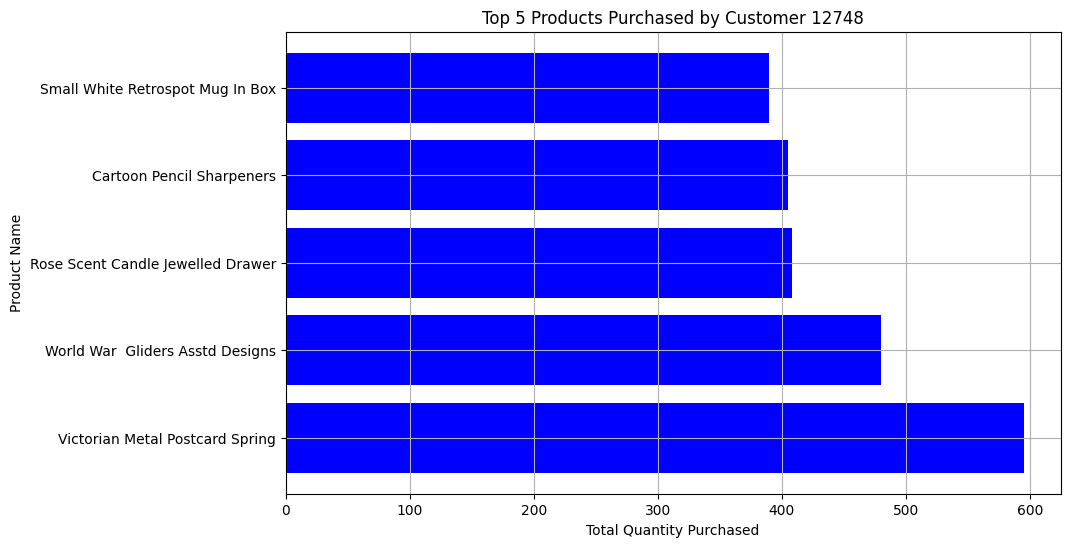

The above plot shows the top 5 products purchased by the most frequent customer (CustomerNo: 12748), based on the quantity purchased.


In [7]:
# Task 1.5.1: Determine the shopping frequency of customers (filter out non-shopping transactions)
# Filter out transactions where Quantity <= 0
valid_transactions = transaction.filter(transaction["Quantity"] > 0)

# Calculate the distinct count of transactionNo for each customer
shopping_frequency = valid_transactions.groupBy("CustomerNo").agg(countDistinct("transactionNo").alias("ShoppingFrequency"))

# Identify the customer who shops most frequently
most_frequent_customer = shopping_frequency.orderBy("ShoppingFrequency", ascending=False).first()

# Display the customer who shops most frequently and their shopping frequency
print(f"Customer with the highest shopping frequency: {most_frequent_customer['CustomerNo']} \
with {most_frequent_customer['ShoppingFrequency']} distinct transactions")

# Task 1.5.2: Find out what products this customer typically buys based on the Quantity
# Filter transactions for the most frequent customer
customer_transactions = valid_transactions.filter(valid_transactions["CustomerNo"] == most_frequent_customer["CustomerNo"])

# Aggregate the total Quantity of each product purchased by this customer
customer_product_quantities = customer_transactions.groupBy("productName_process").agg(_sum("Quantity").alias("TotalQuantity"))

# Identify the products this customer typically buys (sorted by Quantity)
top_products = customer_product_quantities.orderBy("TotalQuantity", ascending=False)

# Display the top products that the most frequent customer typically buys
top_products.show(truncate=False)

# Output explanation
print("The above output lists the products most frequently purchased by the \
customer with the highest shopping frequency, sorted by the total quantity purchased.\n")

# Optional: Plotting the top products by quantity purchased by the most frequent customer
top_products_pd = top_products.toPandas()

# Plot the top 5 products by quantity purchased
plt.figure(figsize=(10, 6))
plt.barh(top_products_pd['productName_process'].head(5), top_products_pd['TotalQuantity'].head(5), color='blue')
plt.title(f"Top 5 Products Purchased by Customer {most_frequent_customer['CustomerNo']}")
plt.xlabel('Total Quantity Purchased')
plt.ylabel('Product Name')
plt.grid(True)
plt.show()

# Output explanation
print(f"The above plot shows the top 5 products purchased by the most frequent \
customer (CustomerNo: {most_frequent_customer['CustomerNo']}), based on the quantity purchased.")

For Question 1.5, customer transactions were analyzed to identify the customer with the highest shopping frequency. Additionally, the top products typically purchased by this customer were determined, which can inform personalized marketing strategies.

### Answer 1.6

In [8]:
# Task 1.6.1: Filter the dataframe to include only rows where Quantity > 0
df = df[df['Quantity'] > 0]

# Group by transactionNo and aggregate product_category and productName_process into lists
df_grouped = df.groupby('transactionNo').agg({
    'product_category': lambda x: list(x),
    'productName_process': lambda x: list(x)
}).reset_index()

# Display the first 10 rows of the grouped dataframe to verify the result
print(df_grouped.head(10))

# Output explanation
print("\nThe above output shows the dataframe after filtering for positive quantities and grouping by transactionNo to aggregate product categories and product names into lists.\n")

# Task 1.6.2: Remove adjacent duplicates from the product_category lists
def remove_adjacent_duplicates(lst):
    return [v for i, v in enumerate(lst) if i == 0 or v != lst[i-1]]

# Apply the function to the product_category column
df_grouped['product_category'] = df_grouped['product_category'].apply(remove_adjacent_duplicates)

# Save the processed dataframe as 'df_1'
df_1 = df_grouped

# Display the first 10 rows of the processed dataframe to verify the changes
print(df_1.head(10))

# Output explanation
print("\nThe above output shows the dataframe after removing adjacent duplicates from the product_category lists and saving the processed dataframe as 'df_1'.\n")



  transactionNo                                   product_category  \
0        536365                [0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca]   
1        536366                                         [0ca, 0ca]   
2        536367  [0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, ...   
3        536368                               [0ca, 0ca, 0ca, 0ca]   
4        536369                                              [0ca]   
5        536370  [0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, ...   
6        536371                                              [0ca]   
7        536372                                         [0ca, 0ca]   
8        536373  [0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, ...   
9        536374                                              [0ca]   

                                 productName_process  
0  [Cream Hanging Heart TLight Holder, White Moro...  
1  [Hand Warmer Union Jack, Hand Warmer Red Retro...  
2  [Assorted Colour Bird Ornament, Poppys Playhou...  
3  [Jam M

### Answer 1.7

  transactionNo product_category  \
0        536365            [0ca]   
1        536366            [0ca]   
2        536367            [0ca]   
3        536368            [0ca]   
4        536369            [0ca]   

                                 productName_process  prod_len  
0  [Cream Hanging Heart TLight Holder, White Moro...         1  
1  [Hand Warmer Union Jack, Hand Warmer Red Retro...         1  
2  [Assorted Colour Bird Ornament, Poppys Playhou...         1  
3  [Jam Making Set With Jars, Red Coat Rack Paris...         1  
4                         [Bath Building Block Word]         1  

The above output shows the first 5 rows of the dataframe 'df_1' after adding the 'prod_len' column, which indicates the length of the product_category list for each transaction.

   transactionNo           product_category  \
13        536378            [0ca, 1ca, 0ca]   
27        536395            [0ca, 1ca, 0ca]   
36        536404  [0ca, 1ca, 0ca, 4ca, 0ca]   
40        536408         

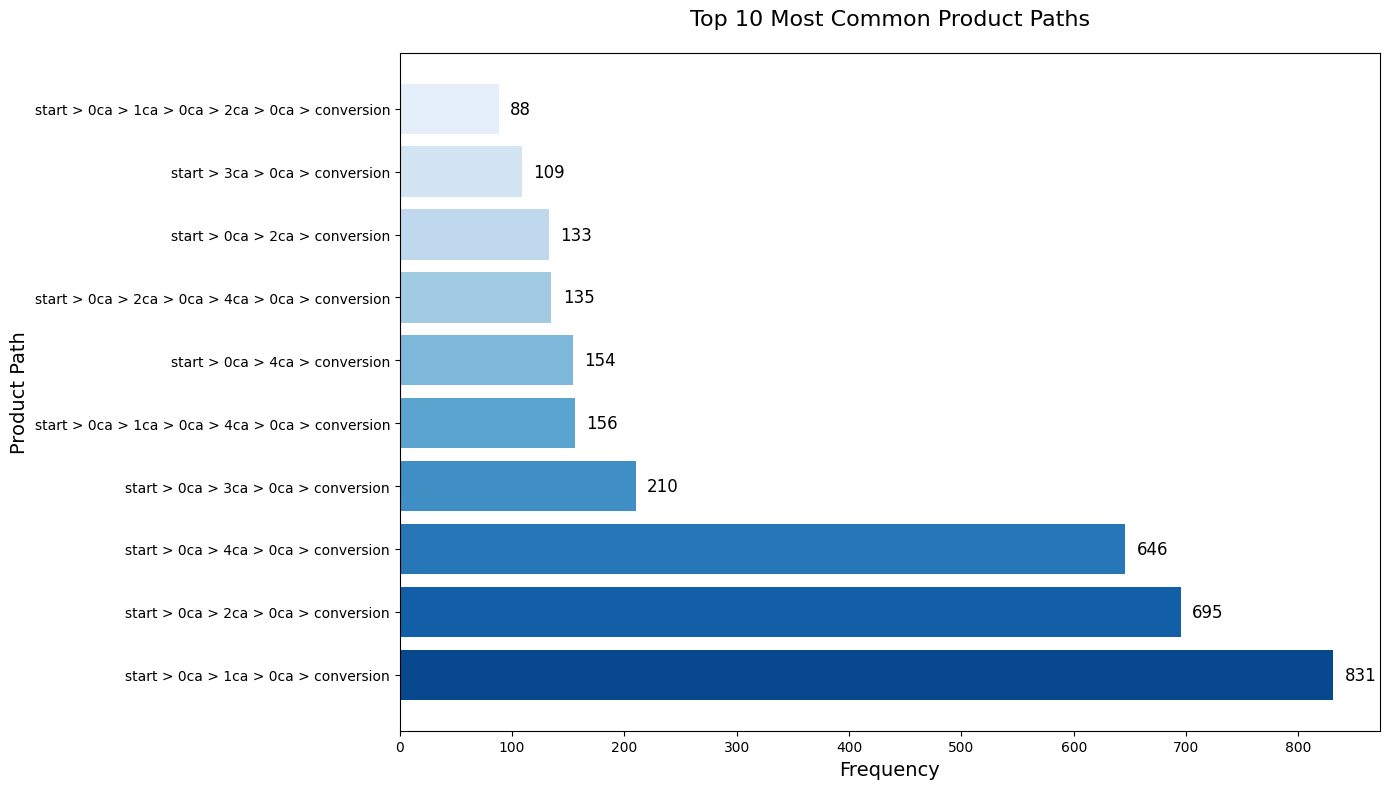

In [9]:
# Task 1.7.1: Add a new column 'prod_len' that represents the length of the product_category list for each transaction
df_1['prod_len'] = df_1['product_category'].apply(len)

# Display the first 5 rows of df_1 to verify the addition of the 'prod_len' column
print(df_1.head(5))

# Output explanation
print("\nThe above output shows the first 5 rows of the dataframe 'df_1' after adding the 'prod_len' column, which indicates the length of the product_category list for each transaction.\n")

# Task 1.7.2: Define a function to process the data by creating a 'path' column using str.replace() and filtering based on product category list length
def data_processing(df, maxlength=5, minlength=2):
    # Convert the product_category list into a string and format it into a path string using str.replace()
    df['path'] = df['product_category'].apply(lambda x: str(x).replace('[', 'start > ').replace(']', ' > conversion').replace(', ', ' > ').replace("'", ""))

    # Filter the DataFrame based on the length of the product category list, keeping rows within the specified range
    df_2 = df[(df['prod_len'] <= maxlength) & (df['prod_len'] >= minlength)]

    return df_2

# Apply the data_processing function to df_1 with maxlength=5 and minlength=2
df_2 = data_processing(df_1, maxlength=5, minlength=2)

# Display the top 10 rows of df_2 to verify the results
print(df_2.head(10))

# Output explanation
print("\nThe above output shows the top 10 rows of the dataframe 'df_2' after processing the product category lists into paths using str.replace() and filtering based on the list length.\n")

# Visualization: Plotting the Top 10 Most Common Product Paths
path_counts = Counter(df_2['path'])
paths, frequencies = zip(*path_counts.most_common(10))

plt.figure(figsize=(14, 8))
colors = sns.color_palette("Blues_r", len(frequencies))
bars = plt.barh(paths, frequencies, color=colors)
plt.title('Top 10 Most Common Product Paths', fontsize=16, pad=20)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Product Path', fontsize=14)

for bar, freq in zip(bars, frequencies):
    plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2, f'{freq}', va='center', fontsize=12)

plt.tight_layout()
plt.show()

The bar plot visualizes the key output of question 1.7.2, showing the most common paths customers follow when purchasing products. This visualization ties directly back to the analysis objective of understanding customer behavior in terms of product category transitions during transactions.

### Answer 1.8

Number of transactions ending with specific patterns:
0ca > conversion: 3056
1ca > conversion: 26
2ca > conversion: 144
3ca > conversion: 68
4ca > conversion: 198

The above output shows the number of transactions in 'df_2' that end with each of the specified patterns.
------

Number of occurrences of specific substrings in transactions:
0ca > 0ca: 0
0ca > 1ca: 1222
0ca > 2ca: 1137
0ca > 3ca: 343
0ca > 4ca: 1198
0ca > conversion: 3056

The above output shows the total number of occurrences of each specified substring pattern in the transactions within 'df_2'.
------

Total occurrences of the pattern '... > 0ca > ...' in transactions: 6956

The above output shows the total number of occurrences of the pattern '... > 0ca > ...' in the transactions within 'df_2'.
------

Sum of the ratios of substring occurrences to the general pattern occurrence: 1.0

The above output shows the sum of the ratios of specific substring occurrences to the general pattern occurrence in the transactions withi

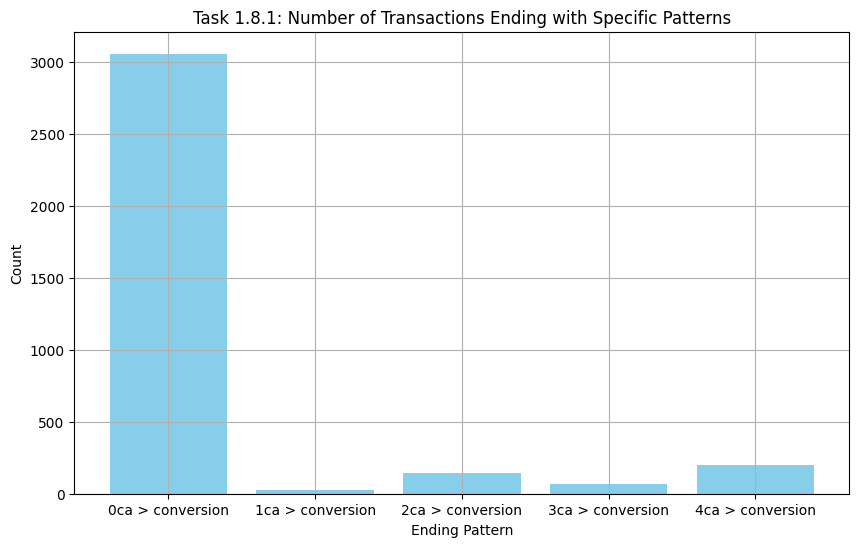

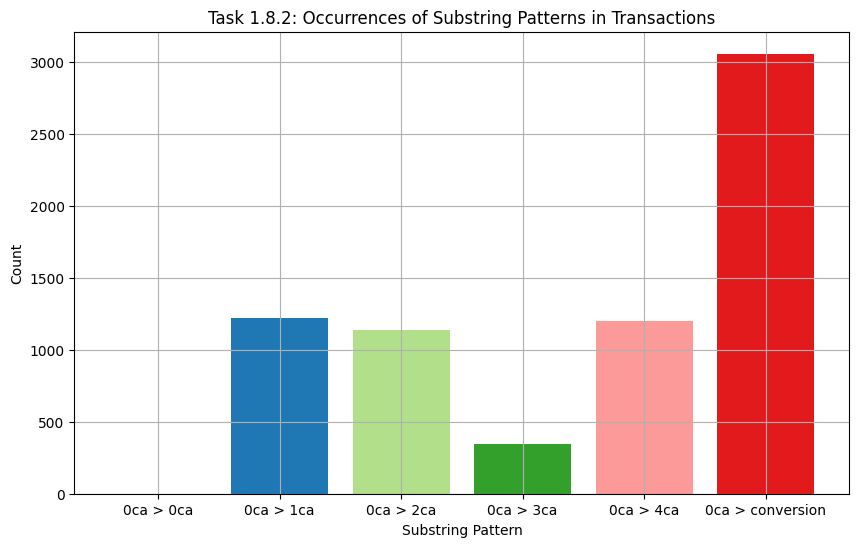

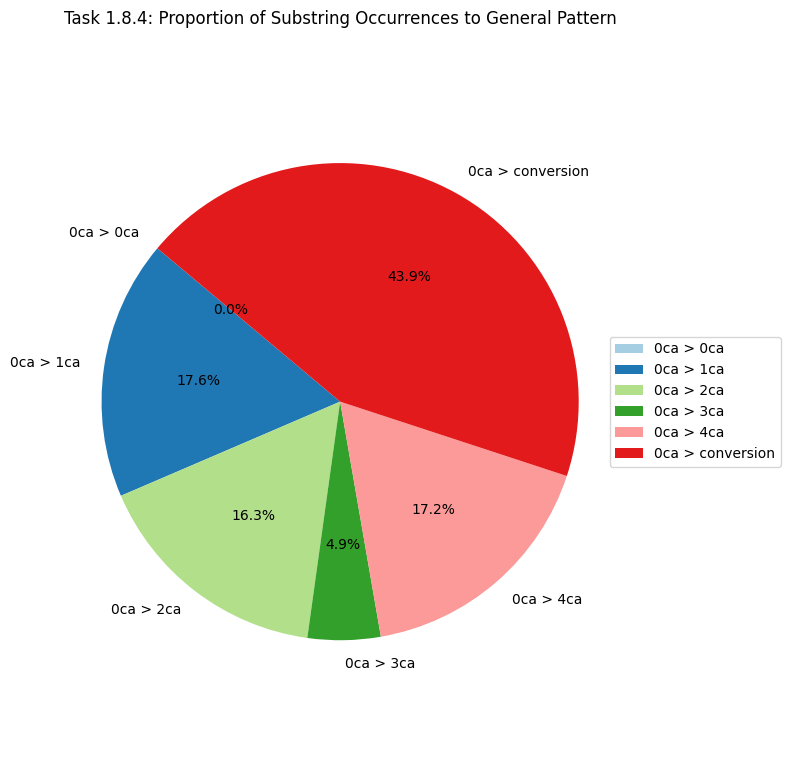

In [10]:
# Task 1.8: Analyze transaction patterns in df_2

# Define the patterns to search for in 1.8.1 and 1.8.2
end_patterns = ['0ca > conversion', '1ca > conversion', '2ca > conversion', '3ca > conversion', '4ca > conversion']
substring_patterns = ['0ca > 0ca', '0ca > 1ca', '0ca > 2ca', '0ca > 3ca', '0ca > 4ca', '0ca > conversion']
general_pattern = '0ca'

# Initialize dictionaries to store the counts for end patterns and substring patterns
end_counts = {pattern: 0 for pattern in end_patterns}
substring_counts = {pattern: 0 for pattern in substring_patterns}

# Initialize the general pattern count for 1.8.3
general_count = 0

# Loop through each transaction path in df_2 to calculate the counts
for path in df_2['path']:
    # Task 1.8.1: Count the number of transactions ending with specific patterns
    for pattern in end_patterns:
        if path.endswith(pattern):
            end_counts[pattern] += 1
    # Task 1.8.2: Count the occurrences of specific substring patterns in the transactions
    for pattern in substring_patterns:
        substring_counts[pattern] += path.count(pattern)
    # Task 1.8.3: Count the total occurrences of the general pattern '... > 0ca > ...'
    general_count += path.count(f'> {general_pattern} >')

# Display the counts for Task 1.8.1
print("Number of transactions ending with specific patterns:")
for pattern, count in end_counts.items():
    print(f"{pattern}: {count}")

# Output explanation
print("\nThe above output shows the number of transactions in 'df_2' that end with each of the specified patterns.\n------\n")

# Display the counts for Task 1.8.2
print("Number of occurrences of specific substrings in transactions:")
for pattern, count in substring_counts.items():
    print(f"{pattern}: {count}")

# Output explanation
print("\nThe above output shows the total number of occurrences of each specified substring pattern in the transactions within 'df_2'.\n------\n")

# Display the result for Task 1.8.3
print(f"Total occurrences of the pattern '... > 0ca > ...' in transactions: {general_count}")

# Output explanation
print("\nThe above output shows the total number of occurrences of the pattern '... > 0ca > ...' in the transactions within 'df_2'.\n------\n")

# Task 1.8.4: Compute the ratio of each substring occurrence from 1.8.2 to the general pattern count from 1.8.3 and sum them
if general_count > 0:
    ratios_sum = sum(substring_counts[pattern] / general_count for pattern in substring_patterns)
else:
    ratios_sum = 0  # To handle division by zero

# Display the result for Task 1.8.4
print(f"Sum of the ratios of substring occurrences to the general pattern occurrence: {ratios_sum}")

# Output explanation
print("\nThe above output shows the sum of the ratios of specific substring occurrences to the general pattern occurrence in the transactions within 'df_2'.\n------\n")

proportions = [substring_counts[pattern] / general_count for pattern in substring_patterns]


# Visualization: Bar Chart for Ending Patterns (Task 1.8.1)
plt.figure(figsize=(10, 6))
plt.bar(end_counts.keys(), end_counts.values(), color='skyblue')
plt.title('Task 1.8.1: Number of Transactions Ending with Specific Patterns')
plt.xlabel('Ending Pattern')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Visualization: Stacked Bar Chart for Substring Occurrences (Task 1.8.2)
# Prepare data for stacked bar chart
substring_data = [substring_counts[pattern] for pattern in substring_patterns]

# Stacked bar chart for substring occurrences
plt.figure(figsize=(10, 6))
plt.bar(substring_patterns, substring_data, color=plt.cm.Paired.colors)
plt.title('Task 1.8.2: Occurrences of Substring Patterns in Transactions')
plt.xlabel('Substring Pattern')
plt.ylabel('Count')
plt.grid(True)
plt.show()


#Pie Chart Visualization
plt.figure(figsize=(8, 8))
plt.pie(proportions, labels=substring_patterns, autopct='%1.1f%%', colors=plt.cm.Paired.colors, startangle=140)
plt.title('Task 1.8.4: Proportion of Substring Occurrences to General Pattern')
plt.axis('equal')
plt.legend(substring_patterns, loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### Answer 1.9

Transaction-Level Product DataFrame:
productName_process   Cake Cases Vintage Christmas   Ribbons Rustic Charm  \
transactionNo                                                               
536365                                         0.0                    0.0   
536367                                         0.0                    0.0   
536370                                         0.0                    0.0   
536371                                         0.0                    0.0   
536373                                         0.0                    0.0   

productName_process   Sweetheart Fairy Cake Cases   Teatime Fairy Cake Cases  \
transactionNo                                                                  
536365                                        0.0                        0.0   
536367                                        0.0                        0.0   
536370                                        0.0                        0.0   
536371                 

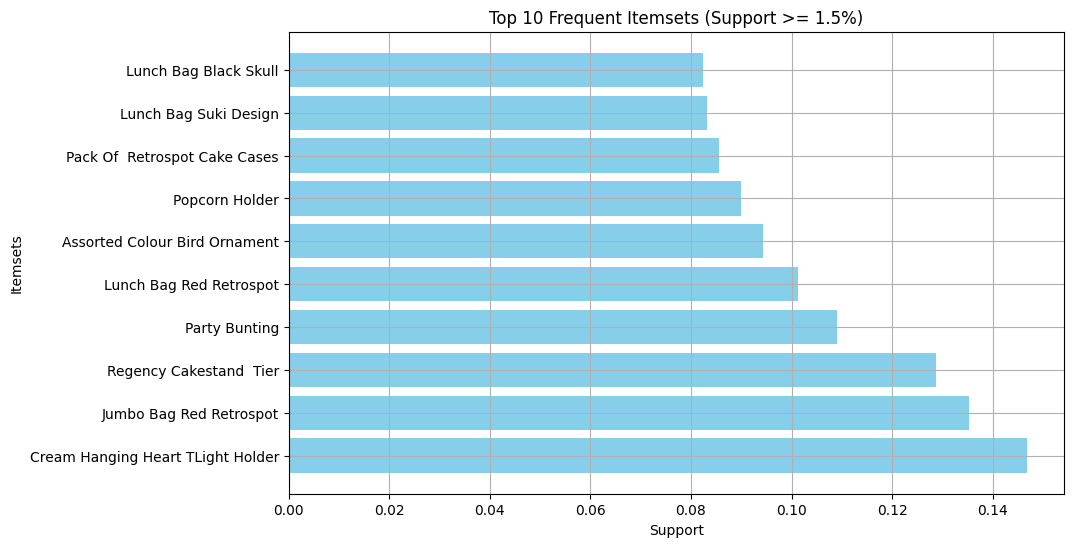


Association Rules with Support >= 1.0% and Lift > 10:
                     antecedents                    consequents  \
0  (Red Retrospot Charlotte Bag)  (Charlotte Bag Pink Polkadot)   
1  (Charlotte Bag Pink Polkadot)  (Red Retrospot Charlotte Bag)   
2     (Strawberry Charlotte Bag)  (Charlotte Bag Pink Polkadot)   
3  (Charlotte Bag Pink Polkadot)     (Strawberry Charlotte Bag)   
4     (Strawberry Charlotte Bag)    (Charlotte Bag Suki Design)   

   antecedent support  consequent support   support  confidence       lift  \
0            0.066887            0.048063  0.033767    0.504836  10.503706   
1            0.048063            0.066887  0.033767    0.702557  10.503706   
2            0.046704            0.048063  0.024516    0.524931  10.921809   
3            0.048063            0.046704  0.024516    0.510094  10.921809   
4            0.046704            0.057054  0.026845    0.574792  10.074505   

   leverage  conviction  zhangs_metric  
0  0.030552    1.922467       0.

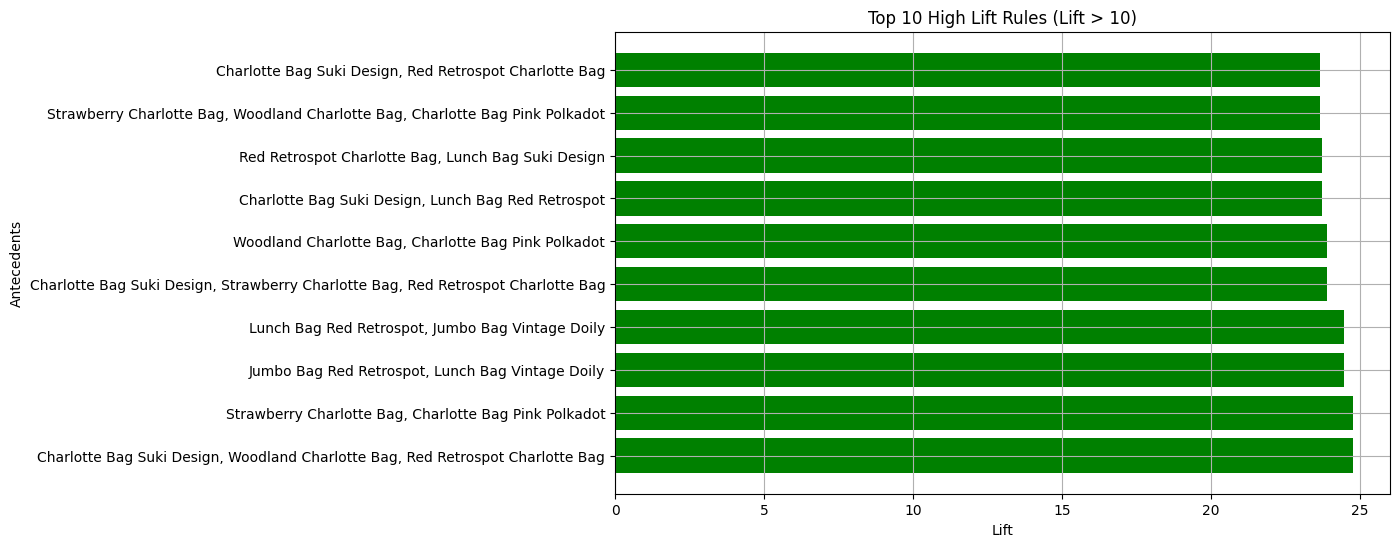


High Confidence Rules (Confidence >= 0.8):
                                         antecedents  \
0  (Charlotte Bag Suki Design, Charlotte Bag Pink...   
1  (Lunch Bag Apple Design, Charlotte Bag Pink Po...   
2  (Lunch Bag Black Skull, Charlotte Bag Pink Pol...   
3  (Lunch Bag Cars Blue, Charlotte Bag Pink Polka...   
4  (Lunch Bag Spaceboy Design, Charlotte Bag Pink...   

                     consequents  antecedent support  consequent support  \
0  (Red Retrospot Charlotte Bag)            0.026522            0.066887   
1  (Red Retrospot Charlotte Bag)            0.013520            0.066887   
2  (Red Retrospot Charlotte Bag)            0.017530            0.066887   
3  (Red Retrospot Charlotte Bag)            0.016301            0.066887   
4  (Red Retrospot Charlotte Bag)            0.015007            0.066887   

    support  confidence       lift  leverage  conviction  zhangs_metric  
0  0.021282    0.802439  11.997007  0.019508    4.723167       0.941619  
1  0.011062   

In [11]:
# Task 1.9.1: Filter the dataframe and pivot to create a transaction-level product dataframe

# Filter out negative quantities and keep only the top 100 products based on total quantity sold
top_100_products = df.groupby('productName_process')['Quantity'].sum().nlargest(100).index
df_filtered = df[(df['productName_process'].isin(top_100_products)) & (df['Quantity'] > 0)]

# Pivot the dataframe to create the transaction-level product dataframe
transaction_df = df_filtered.pivot_table(index='transactionNo', columns='productName_process', values='Quantity', fill_value=0)

# Display the first 5 rows of the pivoted dataframe
print("Transaction-Level Product DataFrame:")
print(transaction_df.head(5))

# Output explanation
print("\nThe above output shows the first 5 rows of the transaction-level product dataframe, where each row represents a transaction, and each column represents the quantity of a product in that transaction.\n")

# Task 1.9.2: Apply the Apriori algorithm to find frequent itemsets with a minimum support of 1.5%

# Convert the DataFrame to boolean (True/False) where a product is present or not
transaction_df_bool = transaction_df > 0

# Run the Apriori algorithm
frequent_itemsets = apriori(transaction_df_bool, min_support=0.015, use_colnames=True)

# Generate association rules with the Apriori algorithm using lift as the metric
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display the first 5 association rules
print("\nAssociation Rules with Minimum Support of 1.5% and Lift > 1.0:")
print(rules.head())

# Output explanation
print("\nThe above output shows the first 5 association rules generated with a minimum support of 1.5% and lift > 1.0.\n")

# Visualization: Plot Top 10 Frequent Itemsets
plt.figure(figsize=(10, 6))
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(lambda x: ', '.join(list(x)))
top_itemsets = frequent_itemsets.nlargest(10, 'support')
plt.barh(top_itemsets['itemsets'], top_itemsets['support'], color='skyblue')
plt.title('Top 10 Frequent Itemsets (Support >= 1.5%)')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.grid(True)
plt.show()

# Task 1.9.3: Apply the Apriori algorithm to identify items with support >= 1.0% and lift > 10

# Run the Apriori algorithm with lower support
frequent_itemsets_low_support = apriori(transaction_df_bool, min_support=0.01, use_colnames=True)

# Generate association rules with high lift
rules_high_lift = association_rules(frequent_itemsets_low_support, metric="lift", min_threshold=10)

# Display the first 5 association rules
print("\nAssociation Rules with Support >= 1.0% and Lift > 10:")
print(rules_high_lift.head())

# Output explanation
print("\nThe above output shows the first 5 association rules generated with support >= 1.0% and lift > 10.\n")

# Visualization: Plot High Lift Rules
plt.figure(figsize=(10, 6))
top_rules_high_lift = rules_high_lift.nlargest(10, 'lift')
plt.barh(top_rules_high_lift['antecedents'].apply(lambda x: ', '.join(list(x))), top_rules_high_lift['lift'], color='green')
plt.title('Top 10 High Lift Rules (Lift > 10)')
plt.xlabel('Lift')
plt.ylabel('Antecedents')
plt.grid(True)
plt.show()

# Task 1.9.4: Explore three more examples with different support, confidence, and lift measurements

# Example 1: High Confidence Rules
rules_high_conf = association_rules(frequent_itemsets_low_support, metric="confidence", min_threshold=0.8)
print("\nHigh Confidence Rules (Confidence >= 0.8):")
print(rules_high_conf.head())

# Example 2: High Lift Rules
rules_very_high_lift = association_rules(frequent_itemsets_low_support, metric="lift", min_threshold=5.0)
print("\nHigh Lift Rules (Lift >= 5.0):")
print(rules_very_high_lift.head())

# Example 3: Lower Support Rules
rules_low_support = association_rules(frequent_itemsets_low_support, metric="support", min_threshold=0.01)
print("\nLow Support Rules (Support >= 1.0%):")
print(rules_low_support.head())

# Output explanation
print("\nThe above output shows the first 5 association rules generated with different configurations for support, confidence, and lift.\n")

### Answer 1.10

Customer-Product DataFrame:
productName_process   Cake Cases Vintage Christmas   Ribbons Rustic Charm  \
CustomerNo                                                                  
12004                                            0                      0   
12008                                            0                      1   
12025                                            0                      0   
12026                                            1                      1   
12031                                            0                      0   

productName_process   Sweetheart Fairy Cake Cases   Teatime Fairy Cake Cases  \
CustomerNo                                                                     
12004                                           0                          0   
12008                                           0                          0   
12025                                           0                          0   
12026                           

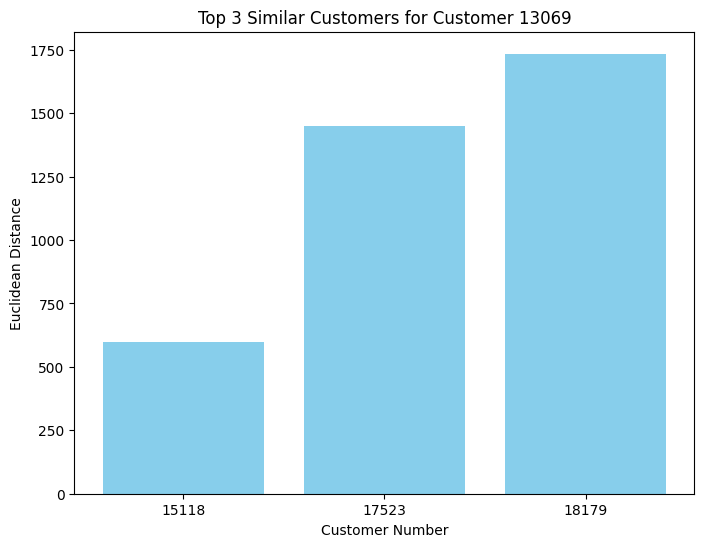

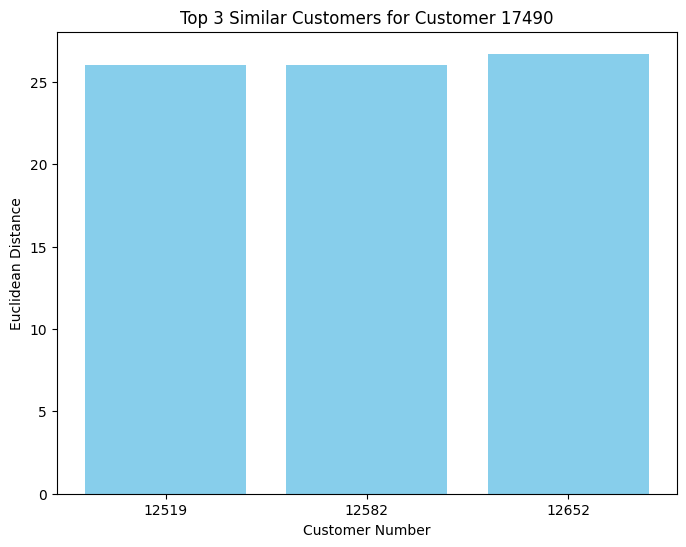

In [12]:
# Task 1.10.1: Create the customer-product dataframe

# Filter out transactions with negative quantities
df_filtered = df[df['Quantity'] > 0]

# Identify the top 100 products by quantity
top_100_products = df_filtered.groupby('productName_process')['Quantity'].sum().nlargest(100).index

# Filter the dataframe to keep only the top 100 products
df_filtered = df_filtered[df_filtered['productName_process'].isin(top_100_products)]

# Create the customer-product dataframe
customer_product_df = df_filtered.pivot_table(index='CustomerNo',
                                              columns='productName_process',
                                              values='Quantity',
                                              aggfunc='sum',
                                              fill_value=0)

# Display the first few rows to verify the DataFrame
print("Customer-Product DataFrame:")
print(customer_product_df.head())

# Task 1.10.2: Calculate pairwise Euclidean distance

# Calculate pairwise Euclidean distance between customers
distances = euclidean_distances(customer_product_df)

# Convert the distance matrix to a DataFrame for easier interpretation
distance_df = pd.DataFrame(distances, index=customer_product_df.index, columns=customer_product_df.index)

# Display the distance DataFrame
print("\nPairwise Euclidean Distance between Customers:")
print(distance_df.head())

# Task 1.10.3: Find the top 3 most similar customers

def find_top_similar_customers(customer_no, distance_df):
    if customer_no in distance_df.index:
        customer_index = distance_df.index.get_loc(customer_no)
        similar_customers = distance_df.iloc[customer_index].argsort()[1:4]
        similar_customers_indices = distance_df.index[similar_customers]
        return similar_customers_indices.tolist(), distance_df.iloc[customer_index, similar_customers].values.tolist()
    else:
        return None, None

# Find top 3 similar customers for CustomerNo 13069 and 17490
similar_customers_13069, distances_13069 = find_top_similar_customers('13069', distance_df)
similar_customers_17490, distances_17490 = find_top_similar_customers('17490', distance_df)

print(f"\nTop 3 similar customers to 13069: {similar_customers_13069} with distances {distances_13069}")
print(f"Top 3 similar customers to 17490: {similar_customers_17490} with distances {distances_17490}")


# Visualization 2: Bar Plot of Top 3 Similar Customers for a Given Customer
def plot_similar_customers(customer_no, similar_customers, distances):
    plt.figure(figsize=(8, 6))
    plt.bar(similar_customers, distances, color='skyblue')
    plt.xlabel('Customer Number')
    plt.ylabel('Euclidean Distance')
    plt.title(f'Top 3 Similar Customers for Customer {customer_no}')
    plt.show()

# Plot for CustomerNo 13069
plot_similar_customers('13069', similar_customers_13069, distances_13069)

# Plot for CustomerNo 17490
plot_similar_customers('17490', similar_customers_17490, distances_17490)

## Task 1.10.4: Coding Logic for Recommending Products to CustomerNo 13069:

### 1. Identify Similar Customers:
Use the euclidean_distances() function on the customer_product_df to calculate the distances between CustomerNo 13069 and all other customers.
Sort the resulting distances in ascending order to find the customers most similar to CustomerNo 13069.
Select the top 3-5 customers with the smallest distance values.
#### Calculate pairwise distances
distances = euclidean_distances(customer_product_df)
#### Create a distance DataFrame for easier access
distance_df = pd.DataFrame(distances, index=customer_product_df.index, columns=customer_product_df.index)
#### Get distances for CustomerNo 13069
similar_customers = distance_df.loc['13069'].sort_values().index[1:4]

### 2. Aggregate Purchase Data from Similar Customers:
For the similar customers identified, aggregate their purchase data using the mean() or sum() function to calculate the average or total quantity purchased for each product.

#### Aggregate the purchase data of similar customers
similar_customers_products = customer_product_df.loc[similar_customers].mean()

### 3. Filter Out Already Purchased Products:

Retrieve the products already purchased by CustomerNo 13069 using .loc[].
Compare the list of products from the similar customers with the list of products that CustomerNo 13069 has already bought.
Use a filter to exclude products that CustomerNo 13069 has already purchased.
#### Get products that CustomerNo 13069 has already purchased
target_customer_products = customer_product_df.loc['13069']
#### Filter out products already purchased by CustomerNo 13069
recommendations = similar_customers_products[(similar_customers_products > 0) & (target_customer_products == 0)]
### 4. Rank Potential Recommendations:

Sort the filtered list of products by the aggregated quantity (using sort_values()), prioritizing those that were purchased more frequently or in larger quantities by similar customers.
#### Rank the remaining products based on the quantity purchased by similar customers
recommendations = recommendations.sort_values(ascending=False)
### 5. Suggest Top Products:

Present the top-ranked products as recommendations. These are the products that CustomerNo 13069 hasn't purchased yet but were popular among similar customers.
#### Final list of recommendations for CustomerNo 13069
print(f"Product recommendations for CustomerNo 13069:")
print(recommendations.head())  # Suggest the top products


# Part 2

### Answer 2.1

In this task, we analyze the revenue time series by handling missing dates and performing seasonal decomposition to identify trends, seasonal patterns, and residuals.


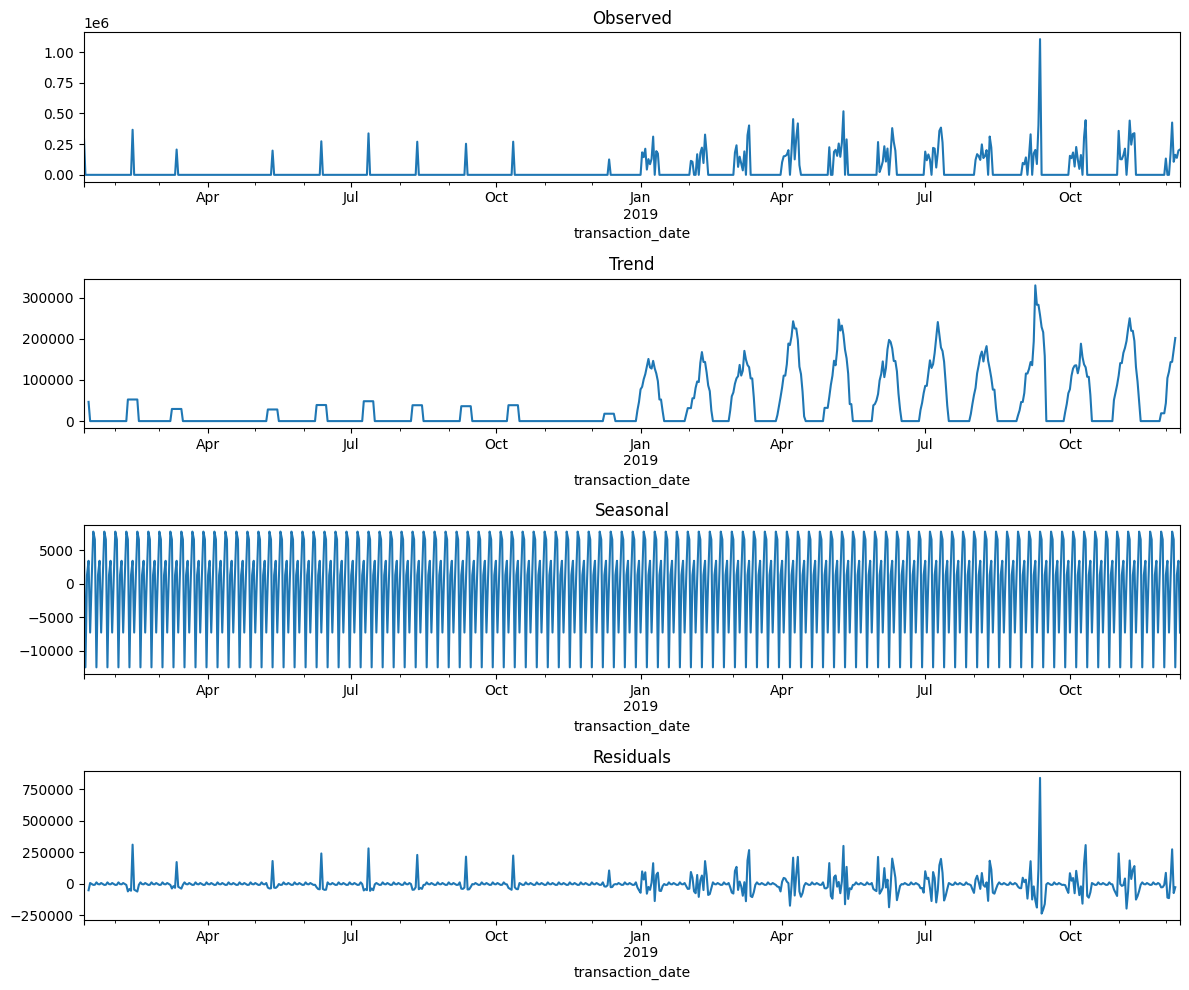

,revenue
transaction_date,
2018-01-12,326820.08
2018-01-13,0.00
2018-01-14,0.00
2018-01-15,0.00
2018-01-16,0.00


In [13]:
# Step 1: Creating a 'revenue' column by multiplying 'price' and 'Quantity'

df['revenue'] = df['price'] * df['Quantity']

# Step 2: Converting the 'Date' column to a datetime format

df['transaction_date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Step 3: Grouping by 'transaction_date' to calculate daily revenue

df_daily_revenue = df.groupby('transaction_date').agg({'revenue': 'sum'}).reset_index()

# Step 4: Setting 'transaction_date' as the index for time series analysis

df_daily_revenue.set_index('transaction_date', inplace=True)

# Step 5: Filling in missing dates by resampling to daily frequency

mean_revenue = df_daily_revenue['revenue'].mean()  # Calculate mean revenue
df_daily_revenue_filled = df_daily_revenue.resample('D').sum().fillna(mean_revenue)  # Fill missing dates with mean

# Step 6: Decomposing the time series using an additive model
decomposition = seasonal_decompose(df_daily_revenue_filled['revenue'], model='additive')

# Step 7: Plotting the decomposition (Observed, Trend, Seasonal, Residuals)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10))
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonal')
decomposition.resid.plot(ax=ax4, title='Residuals')

plt.tight_layout()
plt.show()

# Displaying the first few rows of the filled daily revenue data

df_daily_revenue_filled.head()


1.   **Step 1:** This will give us the total revenue for each transaction.
2.   **Step 2:** This is crucial for time-series analysis and ensures that the dates are in the correct format.
3.   **Step 3:** We want to aggregate the total revenue for each day, not for each transaction.
4.   **Step 5:** Here, we fill in any missing dates and assign the mean revenue to these missing dates.
5.   **Step 6:** Decomposing the time series into its components: observed, trend, seasonal, and residual.
6.   **Step 7:** This will help us understand the different components of the time series.

### Analysis of Results

- **Observed**: Displays the overall revenue trends over time.
- **Trend**: Shows long-term increases or decreases in revenue.
- **Seasonal**: Identifies any recurring patterns, such as weekly or monthly cycles.
- **Residuals**: Represents the randomness or irregularities after removing the trend and seasonal components.

The missing dates were filled with the mean revenue to ensure a continuous time series for analysis.


### Answer 2.2

We will use the ARIMA model to forecast future revenue and find the best model by testing different parameters `(p, d, q)`.

Best ARIMA parameters: (1, 0, 1)
Best Mean Absolute Error (MAE): 92509.39


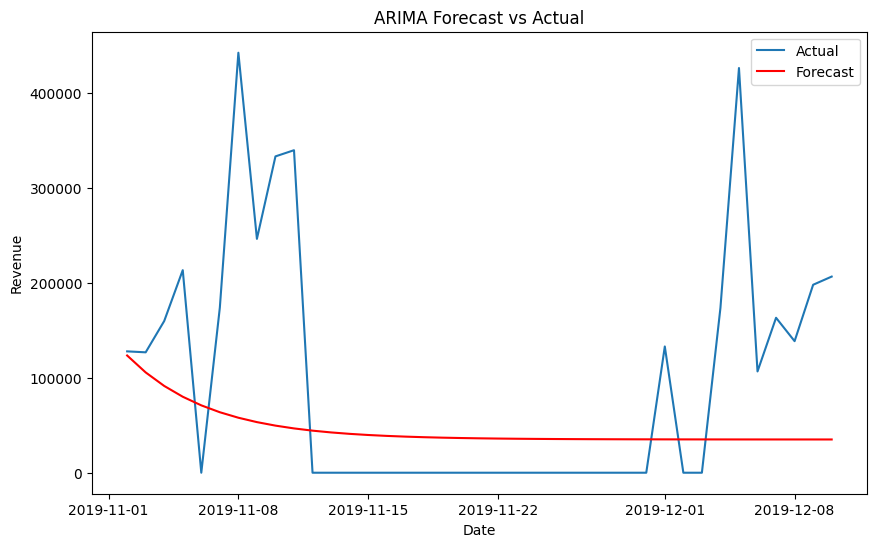

In [14]:
# Ensuring we have the df_daily_revenue_filled data from Answer 2.1

# Step 1: Splitting the data into training and test sets

train = df_daily_revenue_filled.loc[:'2019-11-01']
test = df_daily_revenue_filled.loc['2019-11-02':]

# Step 2: Defining the range for p, d, q values for grid search

p = d = q = range(0, 3)
pdq = [(x, y, z) for x in p for y in d for z in q]

# Step 3: Initializing variables to track the best parameters and the lowest error

best_pdq = None
best_mae = float("inf")

# Step 4: Performing grid search over ARIMA parameters

for param in pdq:
    try:
        # Fitting ARIMA model

        model = ARIMA(train['revenue'], order=param)
        model_fit = model.fit()

        # Forecasting on the test set

        forecast = model_fit.forecast(steps=len(test))

        # Calculating MAE

        mae = mean_absolute_error(test['revenue'], forecast)

        # Updating the best model if the current one is better

        if mae < best_mae:
            best_mae = mae
            best_pdq = param
    except:
        continue

# Step 5: Outputting the best parameters and the corresponding MAE

print(f'Best ARIMA parameters: {best_pdq}')
print(f'Best Mean Absolute Error (MAE): {round(best_mae,2)}')

# Step 6: Fitting the ARIMA model with the best parameters and plotting the forecast vs actual

best_model = ARIMA(train['revenue'], order=best_pdq)
best_model_fit = best_model.fit()

# Forecasting on test set

forecast = best_model_fit.forecast(steps=len(test))

# Plotting the forecasted values against the actual test set

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['revenue'], label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()


### Answer 2.3

In this question, we examine many deep learning techniques for time series forecasting and describe the required procedures for modelling and data preparation.

**Explored Methods:**

**1. LSTM (Long Short-Term Memory Networks):**



*   LSTM, a variant of recurrent neural networks (RNN), can learn long-term dependencies in sequence data.
*   Designed to remember trends over extended periods, LSTMs are extensively used for time series forecasting and fit financial, weather, and other sequential information.



**2. GRU (Gated Recurrent Unit):**



*   Reducing the number of gates (mechanisms for information flow) helps GRU, a variation of LSTM, to simplify the model.
*   On many time series forecasting projects, GRUs perform comparably to LSTMs and are computationally more economical.



**3. TCN (Temporal Convolutional Networks):**



*   Temporal Convolutional Network (TCN) is a convolutional neural network structure specifically developed for sequential data.
*   Because TCNs employ causal convolutions rather than LSTMs and GRUs, predictions made at a particular time step are solely impacted by information from the past.


**Steps for Data Wrangling and Modeling:**

**1. Data Preparation:**


*   **Normalize or Standardize the Data:** Adjust the time series data to fall into a particular range, say between 0 and 1. This makes sure that features with wider numerical ranges are not given more weight by the neural network than others.

  * Utilise programs from libraries like sklearn, such as MinMaxScaler and StandardScaler.

*   **Create Time Windows or Sequences:**

  *   To forecast time series, the data must be organised into sequences (also known as sliding windows) with a set duration.
  *   Each input to the model would have 60 time steps (features), for instance, if the window size was 60. The target value would be the subsequent step or the 61st time step.

*   **Split the Data into Training and Test Sets:**

  *   Typically, training uses 80% of the data while testing uses 20%.
  *   To avoid data leaking, time series data must be divided chronologically rather than arbitrarily (i.e., the model learning from future data).





**2. Model Definition:**

* **LSTM/GRU Model:**

  1.   **Input Shape:** It is necessary to transform the input data into 3D arrays (samples, time steps, features).
  2.   **LSTM Layers:** Describe a layer or layers of LSTM. It is possible to change the quantity of LSTM units (neurones) in every layer. Units of 50, 100, or 200 are typical possibilities.
  3.   **Dense Layers:** To forecast the output for the upcoming time step, a dense layer is inserted after the LSTM layers.
  4.   **Dropout Layer:** To stop overfitting, dropout layers can be included, which randomly ignore a portion of the neurones during training.

* **Temporal Convolutional Networks (TCN):**

  1.   **Casual Convolutional Layers:** To make sure that previous data is the only factor influencing predictions, define convolutional layers using **causal convolutions**.
  2.   **Dilated Convolutions:** To exponentially expand the receptive field—that is, the volume of historical data the model takes into account—use dilated convolutions.
  3.   **Residual Connections:** To stabilise and enhance the model's capacity to manage long-term dependencies, add residual connections.

* **Compile the Model:** For regression problems, use a suitable loss function such as **Mean Squared Error (MSE)**, and select an optimiser such as **Adam** to minimise the loss during training.

**3. Model Training:**

  *   **Train the Model:** Use the training set to train the model for a predetermined number of epochs (e.g., 20-100 epochs). To enhance the performance of the model, one can adjust the batch size and number of epochs.
  *   **Early Stopping:** Throughout training, keep an eye on validation loss and halt the model if it begins to overfit (validation loss increases).



**4. Evaluate the Model:**

  *   **Evaluate on the Test Set:** Utilise metrics such as **Mean Absolute Error (MAE)** or **Mean Squared Error (MSE)** to assess the model's performance after training.
  *   **Make Predictions:** Future time steps can be predicted by using the trained model. Utilising the scaler's inverse transform, return the predictions to their initial scale.



**5. Visualize the Results:**

  *   Plotting real vs. projected numbers will allow to visually evaluate the model's performance.

**References:**

*   **Bai, S., Kolter, J. Z., & Koltun, V. (2018).** An empirical evaluation of generic convolutional and recurrent networks for sequence modeling. arXiv preprint arXiv:1803.01271. https://doi.org/10.48550/arXiv.1803.01271

*   **Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014).** Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555. https://doi.org/10.48550/arXiv.1412.3555

*   **Hochreiter, S., & Schmidhuber, J. (1997).** Long short-term memory. Neural Computation, 9(8), 1735–1780. https://doi.org/10.1162/neco.1997.9.8.1735